In [1]:
import pandas as pd
import numpy as np
import os
import ast
import argparse
import sys
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import processing as pr


Data processing completed.


In [2]:
df = pd.read_csv('phase3_oncology_2011_api.csv')

In [3]:
df

,protocolSection_identificationModule_nctId,protocolSection_identificationModule_orgStudyIdInfo_id,protocolSection_identificationModule_organization_fullName,protocolSection_identificationModule_organization_class,protocolSection_identificationModule_briefTitle,protocolSection_identificationModule_officialTitle,protocolSection_statusModule_statusVerifiedDate,protocolSection_statusModule_overallStatus,protocolSection_statusModule_expandedAccessInfo_hasExpandedAccess,protocolSection_statusModule_startDateStruct_date,...,protocolSection_oversightModule_isUsExport,protocolSection_eligibilityModule_genderBased,protocolSection_eligibilityModule_genderDescription,protocolSection_statusModule_expandedAccessInfo_nctId,protocolSection_statusModule_expandedAccessInfo_statusForNctId,protocolSection_referencesModule_availIpds,protocolSection_identificationModule_nctIdAliases,protocolSection_oversightModule_isUnapprovedDevice,protocolSection_identificationModule_orgStudyIdInfo_type,protocolSection_identificationModule_orgStudyIdInfo_link
0,NCT02794324,CCR3593,Royal Marsden NHS Foundation Trust,OTHER,The HeartSpare Study (Stage I),Optimisation and Individualisation of Heart-Sp...,2016-06,COMPLETED,False,2012-02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NCT02125344,GBG 84,German Breast Group,OTHER,"A Phase III Trial Comparing Two Dose-dense, Do...",A Randomized Phase III Trial Comparing Two Dos...,2017-07,COMPLETED,False,2014-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NCT03306992,HCI104671,University of Utah,OTHER,Precision-exercise-prescription for Lung Cance...,A Phase III Randomized Study Comparing the Eff...,2023-06,COMPLETED,False,2017-11-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NCT01901692,AMC IRB 2013-0627,Asan Medical Center,OTHER,Sorafenib vs.TransArterial Chemoembolization P...,Randomized Trial Comparing Sorafenib and Trans...,2017-09,COMPLETED,False,2013-07-29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NCT01154192,081696,"University of California, San Diego",OTHER,Theca Cell Function in Adolescents With Polycy...,Theca Cell Function in Adolescents With Polycy...,2019-04,COMPLETED,False,2011-08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1629,NCT03825887,CCHE -BM0001,Children's Cancer Hospital Egypt 57357,OTHER,Nalbuphine Versus Morphine for Mucositis Pain ...,Evaluation of Safety and Efficacy of Nalbuphin...,2020-07,COMPLETED,False,2018-02-01,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1630,NCT01962987,71204901,Actavis Inc.,INDUSTRY,A Study Comparing Diclofenac Sodium Gel 3% to ...,"A Randomized, Double-Blind, Multiple-Site, Pla...",2020-07,COMPLETED,False,2013-03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1631,NCT01523587,1200.125,Boehringer Ingelheim,INDUSTRY,LUX-Lung 8: A Phase III Trial of Afatinib (BIB...,"LUX-Lung 8: A Randomized, Open-label Phase III...",2019-02,COMPLETED,False,2012-03-05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1632,NCT02576054,V501-200,Merck Sharp & Dohme LLC,INDUSTRY,Safety and Tolerability Study of V501 in Japan...,"A Phase III, Open-Label, Clinical Trial to Stu...",2019-11,COMPLETED,False,2015-11-20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df['start_date'] = df['protocolSection_statusModule_startDateStruct_date'].apply(pr.convert_to_datetime)
df['primary_completion_date'] = df['protocolSection_statusModule_primaryCompletionDateStruct_date'].apply(pr.convert_to_datetime)
df['completion_date'] = df['protocolSection_statusModule_completionDateStruct_date'].apply(pr.convert_to_datetime)
df['primary_study_duration_days'] = (df['primary_completion_date'] - df['start_date']).dt.days
df['study_duration_days'] = (df['completion_date'] - df['start_date']).dt.days

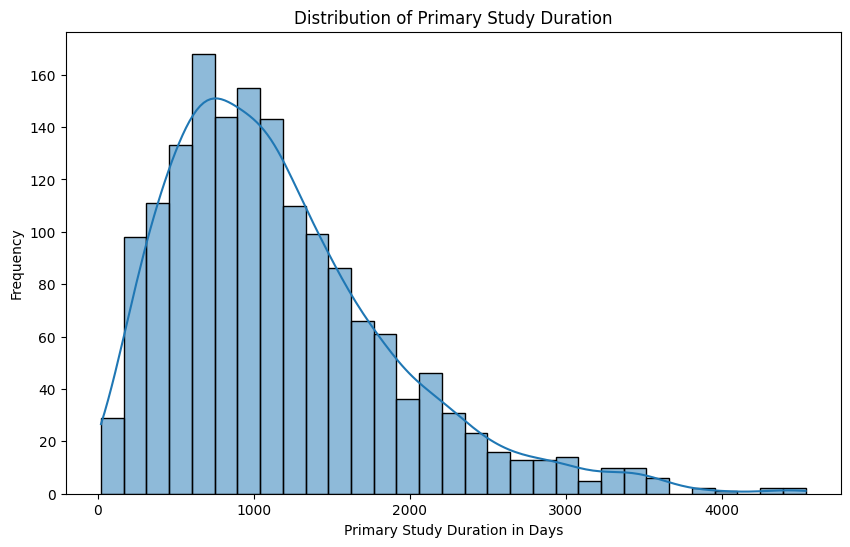

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(df['primary_study_duration_days'].dropna(), kde=True)
plt.title('Distribution of Primary Study Duration')
plt.xlabel('Primary Study Duration in Days')
plt.ylabel('Frequency')
plt.show()

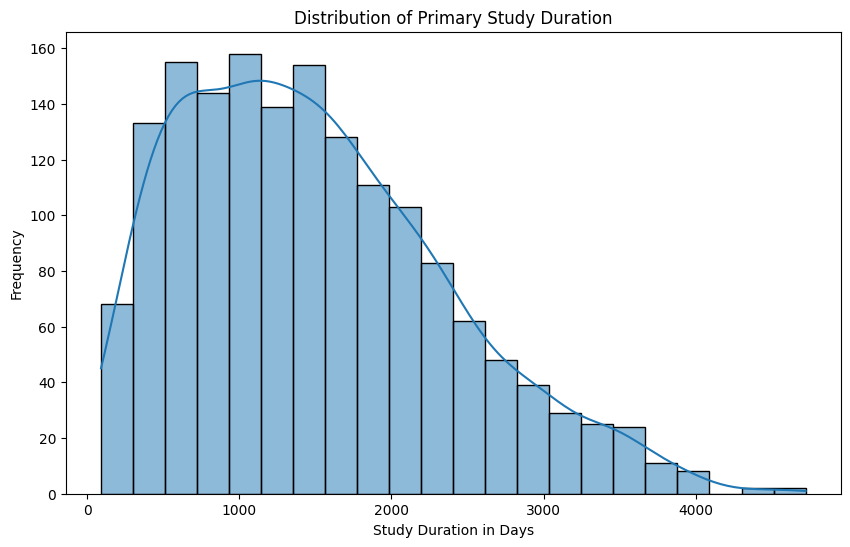

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(df['study_duration_days'].dropna(), kde=True)
plt.title('Distribution of Primary Study Duration')
plt.xlabel('Study Duration in Days')
plt.ylabel('Frequency')
plt.show()

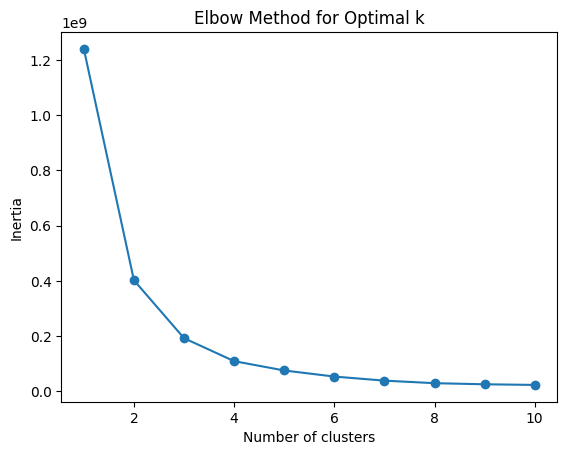

In [15]:
X = df[['study_duration_days']]

# Specify a range of clusters
clusters_range = range(1, 11)
inertia = []

# Calculate inertia (within-cluster sum of squares) for each k
for k in clusters_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow curve
plt.plot(clusters_range, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [19]:
# drop rows with NaNs in study_duration_days or primary_study_duration_days
df = df.dropna(subset=['study_duration_days', 'primary_study_duration_days']).copy()

n_intervals = 3

kmeans_study = KMeans(n_clusters=n_intervals, random_state=42)
df['study_cluster'] = kmeans_study.fit_predict(df[['study_duration_days']])
# centroids = kmeans_study.cluster_centers_.flatten()
# sorted_centroids = np.sort(centroids)
# bin_edges = np.concatenate(([df['study_duration_days'].min()], sorted_centroids, [df['study_duration_days'].max()]))
# bin_edges = np.concatenate(([df['study_duration_days'].min()], sorted_centroids, [df['study_duration_days'].max()]))


# Ensure bin edges do not create extra bins by adding small epsilon to max
# epsilon = 1e-10
# bin_edges[-1] += epsilon

# # Fit K-Means for primary_study_duration_days
# kmeans_primary_study = KMeans(n_clusters=n_intervals, random_state=42)
# df['primary_study_cluster'] = kmeans_primary_study.fit_predict(df[['primary_study_duration_days']])

# Assign intervals based on cluster centroids for each column
df['study_duration_bins'] = pd.cut(df['study_duration_days'], bins=np.sort(kmeans_study.cluster_centers_.flatten()))

# df['study_duration_bins'] = pd.cut(df['study_duration_days'], bins=bin_edges, include_lowest=True)
# df['primary_study_duration_bins'] = pd.cut(df['primary_study_duration_days'], bins=np.sort(kmeans_primary_study.cluster_centers_.flatten()))
df

,protocolSection_identificationModule_nctId,protocolSection_identificationModule_orgStudyIdInfo_id,protocolSection_identificationModule_organization_fullName,protocolSection_identificationModule_organization_class,protocolSection_identificationModule_briefTitle,protocolSection_identificationModule_officialTitle,protocolSection_statusModule_statusVerifiedDate,protocolSection_statusModule_overallStatus,protocolSection_statusModule_expandedAccessInfo_hasExpandedAccess,protocolSection_statusModule_startDateStruct_date,...,protocolSection_oversightModule_isUnapprovedDevice,protocolSection_identificationModule_orgStudyIdInfo_type,protocolSection_identificationModule_orgStudyIdInfo_link,start_date,primary_completion_date,completion_date,primary_study_duration_days,study_duration_days,study_cluster,study_duration_bins
0,NCT02794324,CCR3593,Royal Marsden NHS Foundation Trust,OTHER,The HeartSpare Study (Stage I),Optimisation and Individualisation of Heart-Sp...,2016-06,COMPLETED,False,2012-02,...,NaN,NaN,NaN,2012-02-01,2014-05-01,2014-05-01,820.0,820.0,2,"(703.794, 1696.273]"
1,NCT02125344,GBG 84,German Breast Group,OTHER,"A Phase III Trial Comparing Two Dose-dense, Do...",A Randomized Phase III Trial Comparing Two Dos...,2017-07,COMPLETED,False,2014-12,...,NaN,NaN,NaN,2014-12-01,2016-11-01,2017-01-30,701.0,791.0,2,"(703.794, 1696.273]"
2,NCT03306992,HCI104671,University of Utah,OTHER,Precision-exercise-prescription for Lung Cance...,A Phase III Randomized Study Comparing the Eff...,2023-06,COMPLETED,False,2017-11-07,...,NaN,NaN,NaN,2017-11-07,2022-05-31,2022-05-31,1666.0,1666.0,0,"(703.794, 1696.273]"
3,NCT01901692,AMC IRB 2013-0627,Asan Medical Center,OTHER,Sorafenib vs.TransArterial Chemoembolization P...,Randomized Trial Comparing Sorafenib and Trans...,2017-09,COMPLETED,False,2013-07-29,...,NaN,NaN,NaN,2013-07-29,2017-01-20,2017-08-31,1271.0,1494.0,0,"(703.794, 1696.273]"
4,NCT01154192,081696,"University of California, San Diego",OTHER,Theca Cell Function in Adolescents With Polycy...,Theca Cell Function in Adolescents With Polycy...,2019-04,COMPLETED,False,2011-08,...,NaN,NaN,NaN,2011-08-01,2014-07-01,2014-09-01,1065.0,1127.0,2,"(703.794, 1696.273]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1629,NCT03825887,CCHE -BM0001,Children's Cancer Hospital Egypt 57357,OTHER,Nalbuphine Versus Morphine for Mucositis Pain ...,Evaluation of Safety and Efficacy of Nalbuphin...,2020-07,COMPLETED,False,2018-02-01,...,NaN,NaN,NaN,2018-02-01,2020-12-31,2020-12-31,1064.0,1064.0,2,"(703.794, 1696.273]"
1630,NCT01962987,71204901,Actavis Inc.,INDUSTRY,A Study Comparing Diclofenac Sodium Gel 3% to ...,"A Randomized, Double-Blind, Multiple-Site, Pla...",2020-07,COMPLETED,False,2013-03,...,NaN,NaN,NaN,2013-03-01,2013-09-01,2013-09-01,184.0,184.0,2,NaN
1631,NCT01523587,1200.125,Boehringer Ingelheim,INDUSTRY,LUX-Lung 8: A Phase III Trial of Afatinib (BIB...,"LUX-Lung 8: A Randomized, Open-label Phase III...",2019-02,COMPLETED,False,2012-03-05,...,NaN,NaN,NaN,2012-03-05,2013-10-21,2017-12-27,595.0,2123.0,0,"(1696.273, 2903.285]"
1632,NCT02576054,V501-200,Merck Sharp & Dohme LLC,INDUSTRY,Safety and Tolerability Study of V501 in Japan...,"A Phase III, Open-Label, Clinical Trial to Stu...",2019-11,COMPLETED,False,2015-11-20,...,NaN,NaN,NaN,2015-11-20,2018-08-08,2018-08-08,992.0,992.0,2,"(703.794, 1696.273]"


In [20]:
df['study_duration_bins'].value_counts(dropna=False)

study_duration_bins
(703.794, 1696.273]     674
NaN                     480
(1696.273, 2903.285]    472
Name: count, dtype: int64

In [21]:
df['study_cluster'].value_counts()

study_cluster
2    700
0    634
1    292
Name: count, dtype: int64

In [23]:
df.loc[df['study_duration_bins'].isna(), 'study_cluster']

7       1
8       2
9       1
13      2
16      2
       ..
1618    1
1619    1
1626    2
1630    2
1633    2
Name: study_cluster, Length: 480, dtype: int32

/var/folders/t7/9qpt6ghx7x132zp3932q2fb80000gn/T/ipykernel_17434/1402352244.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


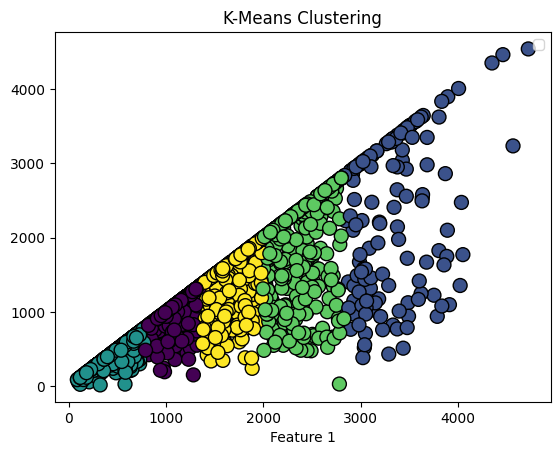

In [10]:
# Get cluster labels and centroids
labels = kmeans_study.labels_
centroids = kmeans_study.cluster_centers_

# Plot data points and color them by their cluster label
plt.scatter(df['study_duration_days'], df['primary_study_duration_days'], c=labels, cmap='viridis', marker='o', edgecolor='k', s=100)


# Adding labels and title
plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
plt.title('K-Means Clustering')
plt.legend()
plt.show()

In [11]:
centroids

array([[1076.62273902],
       [3324.27857143],
       [ 491.87591241],
       [2335.30405405],
       [1647.94642857]])

In [62]:
df['study_duration_bins'].value_counts()

study_duration_bins
(1076.623, 1647.946]    408
(491.876, 1076.623]     402
(1647.946, 2335.304]    345
(2335.304, 3324.279]    212
Name: count, dtype: int64

In [67]:
df['study_duration_bins'].unique()

[(491.876, 1076.623], (1647.946, 2335.304], (1076.623, 1647.946], (2335.304, 3324.279], NaN]
Categories (4, interval[float64, right]): [(491.876, 1076.623] < (1076.623, 1647.946] < (1647.946, 2335.304] < (2335.304, 3324.279]]

In [10]:
# 'study_cluster',
# 'primary_study_cluster',
# 'study_duration_bins',
# 'primary_study_duration_bins'

In [47]:
np.unique(kmeans_study.labels_)

array([0, 1, 2, 3, 4], dtype=int32)

In [9]:
df['study_duration_bins'].value_counts()

study_duration_bins
(505.656, 1132.641]     454
(1132.641, 1733.079]    396
(1733.079, 2407.128]    329
(2407.128, 3352.924]    188
Name: count, dtype: int64

In [13]:
spon_map = {
    'OTHER_GOV': 'OTHER',
    'NETWORK': 'OTHER',
    'NIH': 'OTHER',
    'FED': 'OTHER',
    'INDIV': 'OTHER'
}

spon_map2 = {
    "INDUSTRY": 1,
    "OTHER": 0
}

df['sponsor_type0'] = df['protocolSection_sponsorCollaboratorsModule_leadSponsor_class'].replace(spon_map)
df['sponsor_type'] = df['sponsor_type0'].map(spon_map2)

In [14]:
df['protocolSection_conditionsModule_conditions'] = df['protocolSection_conditionsModule_conditions'].apply(ast.literal_eval)
df['number_of_conditions'] = df['protocolSection_conditionsModule_conditions'].apply(lambda x: len(x))

In [15]:
assign_map = {
    "CROSSOVER": "OTHER",
    "SEQUENTIAL": "OTHER",
    "FACTORIAL": "OTHER"
}

assign_map2 = {
    "SINGLE_GROUP": 0,
    "PARALLEL": 1,
    "OTHER": 2
}

df['intervention_model0'] = df['protocolSection_designModule_designInfo_interventionModel'].replace(assign_map)
df['intervention_model'] = df['intervention_model0'].map(assign_map2)

In [16]:
df['intervention_model'].value_counts(dropna=False)

intervention_model
1.0    1307
0.0     251
2.0      64
NaN       4
Name: count, dtype: int64

In [17]:
# Extract purposes into new columns
df['protocolSection_designModule_designInfo_primaryPurpose'] = df['protocolSection_designModule_designInfo_primaryPurpose'].fillna('')
df['treatment_purpose'] = df['protocolSection_designModule_designInfo_primaryPurpose'].apply(lambda x: 1 if 'TREATMENT' in x else 0)
df['diagnostic_purpose'] = df['protocolSection_designModule_designInfo_primaryPurpose'].apply(lambda x: 1 if 'DIAGNOSTIC' in x else 0)
df['prevention_purpose'] = df['protocolSection_designModule_designInfo_primaryPurpose'].apply(lambda x: 1 if 'PREVENTION' in x else 0)
df['supportive_purpose'] = df['protocolSection_designModule_designInfo_primaryPurpose'].apply(lambda x: 1 if 'SUPPORTIVE_CARE' in x else 0)


In [18]:
# Extract interventions into new columns
df['procedure_intervention'] = df['protocolSection_armsInterventionsModule_interventions'].apply(lambda x: 1 if 'PROCEDURE' in x else 0)
df['device_intervention'] = df['protocolSection_armsInterventionsModule_interventions'].apply(lambda x: 1 if 'DEVICE' in x else 0)
df['behavioral_intervention'] = df['protocolSection_armsInterventionsModule_interventions'].apply(lambda x: 1 if 'BEHAVIORAL' in x else 0)
df['drug_intervention'] = df['protocolSection_armsInterventionsModule_interventions'].apply(lambda x: 1 if 'DRUG' in x else 0)
df['radiation_intervention'] = df['protocolSection_armsInterventionsModule_interventions'].apply(lambda x: 1 if 'RADIATION' in x else 0)
df['biological_intervention'] = df['protocolSection_armsInterventionsModule_interventions'].apply(lambda x: 1 if 'BIOLOGICAL' in x else 0)


In [19]:
df['protocolSection_armsInterventionsModule_armGroups'] = df['protocolSection_armsInterventionsModule_armGroups'].apply(pr.safe_eval)
df['number_of_groups'] = df['protocolSection_armsInterventionsModule_armGroups'].apply(lambda x: len(x) if isinstance(x, list) else 0)


In [20]:
df['protocolSection_armsInterventionsModule_interventions'] = df['protocolSection_armsInterventionsModule_interventions'].apply(eval)
df['intervention_types'] = df['protocolSection_armsInterventionsModule_interventions'].apply(pr.extract_type)
df['number_of_intervention_types'] = df['intervention_types'].apply(len)


In [21]:
age_map = {
    "['ADULT', 'OLDER_ADULT']": "adult",
    "['ADULT']": "adult",
    "['OLDER_ADULT']": "adult",
    "['CHILD']": "youth",
    "['CHILD', 'ADULT']": "youth",
    "['CHILD', 'ADULT', 'OLDER_ADULT']": "all"
}

age_map2 = {
    "youth": 0,
    "adult": 1,
    "all": 2
}
df["age_group0"] = df["protocolSection_eligibilityModule_stdAges"].map(age_map)
df["age_group"] = df["age_group0"].map(age_map2)

In [12]:
df["num_locations"] = df["protocolSection_contactsLocationsModule_locations"].apply(pr.count_loc)


In [36]:
value = df["protocolSection_contactsLocationsModule_locations"][434]
new_string = value.split(", ")
temp_list = []
for i in new_string:
    if "country" in i:
        temp_list.append(i)

temp_list

["'country': 'United States'",
 "'country': 'United States'",
 "'country': 'United States'",
 "'country': 'United States'",
 "'country': 'United States'",
 "'country': 'United States'",
 "'country': 'United States'",
 "'country': 'United States'",
 "'country': 'United States'",
 "'country': 'United States'",
 "'country': 'United States'",
 "'country': 'United States'",
 "'country': 'United States'",
 "'country': 'United States'",
 "'country': 'United States'",
 "'country': 'Argentina'",
 "'country': 'Argentina'",
 "'country': 'Argentina'",
 "'country': 'Argentina'",
 "'country': 'Argentina'",
 "'country': 'Argentina'",
 "'country': 'Australia'",
 "'country': 'Australia'",
 "'country': 'Australia'",
 "'country': 'Australia'",
 "'country': 'Australia'",
 "'country': 'Austria'",
 "'country': 'Austria'",
 "'country': 'Austria'",
 "'country': 'Belgium'",
 "'country': 'Belgium'",
 "'country': 'Belgium'",
 "'country': 'Belgium'",
 "'country': 'Belgium'",
 "'country': 'Brazil'",
 "'country': '

In [37]:
has_us = [i for i in temp_list if "United States" in i]
has_us

["'country': 'United States'",
 "'country': 'United States'",
 "'country': 'United States'",
 "'country': 'United States'",
 "'country': 'United States'",
 "'country': 'United States'",
 "'country': 'United States'",
 "'country': 'United States'",
 "'country': 'United States'",
 "'country': 'United States'",
 "'country': 'United States'",
 "'country': 'United States'",
 "'country': 'United States'",
 "'country': 'United States'",
 "'country': 'United States'"]

In [38]:
if all(i == temp_list[0] for i in temp_list) and has_us:
    print("USA")
elif not has_us:
    print("non-USA")
else:
    print("USA & non-USA")

USA & non-USA


In [34]:
if not has_us:
    print('poo')

poo


In [40]:
def trial_loc(value):
  if pd.isna(value):
    return np.nan
  else:
    new_string = value.split(", ")
    temp_list = []
    for i in new_string:
      if "country" in i:
        temp_list.append(i)
    has_us = [i for i in temp_list if "United States" in i]

    if all(i == temp_list[0] for i in temp_list) and has_us:
        loc = 'USA'
    elif not has_us:
        loc = "non-USA"
    else:
        loc = "USA & non-USA"
    return loc

In [42]:
df['location'] = df["protocolSection_contactsLocationsModule_locations"].apply(trial_loc)
df['location'].value_counts(dropna=False)

location
non-USA          896
USA & non-USA    447
USA              207
NaN               76
Name: count, dtype: int64

In [16]:
# Combine outcome measures
# May need to separate this and re-do outcome measures features depending on our y variable
df['outcome_measures'] = df['protocolSection_outcomesModule_primaryOutcomes'] + df['protocolSection_outcomesModule_secondaryOutcomes']
df['outcome_measures'] = df['outcome_measures'].astype('str')
df['outcome_measures'] = df['outcome_measures'].str.lower()

df['os_outcome_measure'] = df['outcome_measures'].apply(lambda x: 1 if ' OS ' in x else 0) # sometimes abbreviated as OS
df['os_outcome_measure2'] = df['outcome_measures'].apply(lambda x: 1 if 'overall survival' in x else 0) # sometimes fully spelled out

# Make sure there's no overlap
df['os_outcome_measure'] = df['os_outcome_measure'] + df['os_outcome_measure2']
df = df.drop(columns=['os_outcome_measure2'])
df['os_outcome_measure'] = df['os_outcome_measure'].apply(lambda x: x if x==0 else 1)

In [17]:
df['ae_outcome_measure'] = df['outcome_measures'].apply(lambda x: 1 if 'adverse event' in x else 0)

In [18]:
# Duration of Response OM
df['dor_outcome_measure'] = df['outcome_measures'].apply(lambda x: 1 if ' DOR ' in x else 0) # sometimes abbreviated as DOR
df['dor_outcome_measure2'] = df['outcome_measures'].apply(lambda x: 1 if 'duration of response' in x else 0) # sometimes fully spelled out

# Make sure there's no overlap
df['dor_outcome_measure'] = df['dor_outcome_measure'] + df['dor_outcome_measure2']
df = df.drop(columns=['dor_outcome_measure2'])
df['dor_outcome_measure'] = df['dor_outcome_measure'].apply(lambda x: x if x==0 else 1)

In [19]:
df['protocolSection_outcomesModule_primaryOutcomes'] = df['protocolSection_outcomesModule_primaryOutcomes'].apply(pr.safe_eval)
df['protocolSection_outcomesModule_secondaryOutcomes'] = df['protocolSection_outcomesModule_secondaryOutcomes'].apply(pr.safe_eval)

# Applying the function to create the new column
df['primary_measure'] = df['protocolSection_outcomesModule_primaryOutcomes'].apply(pr.extract_measures)
df['secondary_measure'] = df['protocolSection_outcomesModule_secondaryOutcomes'].apply(pr.extract_measures)

# Applying the function to create the new column
df['primary_timeFrame'] = df['protocolSection_outcomesModule_primaryOutcomes'].apply(pr.extract_timeframes)
df['secondary_timeFrame'] = df['protocolSection_outcomesModule_secondaryOutcomes'].apply(pr.extract_timeframes)

In [20]:
df['primary_duration'] = df['primary_timeFrame'].apply(pr.extract_time_length_from_list)
df['secondary_duration'] = df['secondary_timeFrame'].apply(pr.extract_time_length_from_list)

In [21]:
# Applying the function to the dataframe
df['primary_max_days'] = df['primary_duration'].apply(pr.find_max_duration)
df['secondary_max_days'] = df['secondary_duration'].apply(pr.find_max_duration)

In [22]:
df['protocolSection_oversightModule_oversightHasDmc'] = df['protocolSection_oversightModule_oversightHasDmc'].astype('str')
df['protocolSection_oversightModule_oversightHasDmc'] = df['protocolSection_oversightModule_oversightHasDmc'].str.lower()
dmc_map = {
    'true': 1,
    'false': 0,
}
df['has_dmc'] = df['protocolSection_oversightModule_oversightHasDmc'].map(dmc_map)

In [23]:
party_map = {
    "PRINCIPAL_INVESTIGATOR": 0,
    "SPONSOR": 1,
    "SPONSOR_INVESTIGATOR": 2
}

df['resp_party'] = df['protocolSection_sponsorCollaboratorsModule_responsibleParty_type'].map(party_map)

In [24]:
allo_map = {
    'NON_RANDOMIZED': 0,
    'RANDOMIZED': 1
}

df['allocation'] = df['protocolSection_designModule_designInfo_allocation'].map(allo_map)

In [25]:
mask_map = {
    "NONE": 0,
    "SINGLE": 1,
    "DOUBLE": 2,
    "TRIPLE": 3,
    "QUADRUPLE": 4
}

df['masking'] = df['protocolSection_designModule_designInfo_maskingInfo_masking'].map(mask_map)

In [26]:
#make a dataframe with just the columns of interest
cols = [
    'primary_study_duration_days',
    'study_duration_days',
    'number_of_conditions',
    'number_of_groups',
    'age_group',
    'num_locations',
    # 'intervention_types',
    'number_of_intervention_types',
    'sponsor_type',
    'intervention_model',
    'resp_party',
    # 'protocolSection_sponsorCollaboratorsModule_responsibleParty_type',
    'has_dmc',
    # 'protocolSection_oversightModule_oversightHasDmc',
    'protocolSection_designModule_phases',
    'allocation',
    # 'protocolSection_designModule_designInfo_allocation',
    # 'protocolSection_designModule_designInfo_primaryPurpose',
    # 'protocolSection_designModule_designInfo_maskingInfo_masking',
    'masking',
    'protocolSection_designModule_enrollmentInfo_count',
    'protocolSection_eligibilityModule_healthyVolunteers',
    'treatment_purpose',
    'diagnostic_purpose',
    'prevention_purpose',
    'supportive_purpose',
    'procedure_intervention',
    'device_intervention',
    'behavioral_intervention',
    'drug_intervention',
    'radiation_intervention',
    'biological_intervention',
    'os_outcome_measure',
    'dor_outcome_measure',
    'ae_outcome_measure',
    'primary_max_days',
    'secondary_max_days'
    # 'protocolSection_outcomesModule_primaryOutcomes',
    # 'protocolSection_outcomesModule_secondaryOutcomes',
    # 'protocolSection_eligibilityModule_eligibilityCriteria'
]

clean_df = df[cols].copy()
clean_df

,primary_study_duration_days,study_duration_days,number_of_conditions,number_of_groups,age_group,num_locations,number_of_intervention_types,sponsor_type,intervention_model,resp_party,...,device_intervention,behavioral_intervention,drug_intervention,radiation_intervention,biological_intervention,os_outcome_measure,dor_outcome_measure,ae_outcome_measure,primary_max_days,secondary_max_days
0,820.0,820.0,1,3,1,1.0,4,0,2.0,1,...,1,0,0,0,0,0,0,0,28.0,730.0
1,701.0,791.0,7,2,1,1.0,8,0,1.0,1,...,0,0,1,0,0,1,0,0,126.0,1825.0
2,1666.0,1666.0,2,2,1,1.0,1,0,1.0,1,...,0,1,0,0,0,0,0,0,180.0,180.0
3,1271.0,1494.0,1,2,1,1.0,2,0,1.0,0,...,0,0,1,1,0,1,0,0,84.0,1460.0
4,1065.0,1127.0,1,3,0,1.0,2,0,1.0,0,...,0,0,1,0,0,0,0,0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1629,1064.0,1064.0,2,2,0,1.0,2,0,1.0,1,...,0,0,1,0,0,0,0,1,7.0,7.0
1630,184.0,184.0,1,3,1,31.0,2,1,1.0,1,...,0,0,1,0,0,0,0,0,90.0,NaN
1631,595.0,2123.0,1,2,1,192.0,2,1,1.0,1,...,0,0,1,0,0,1,0,0,1058.0,2089.0
1632,992.0,992.0,2,1,0,1.0,1,1,0.0,1,...,0,0,0,0,1,0,0,1,900.0,900.0


In [27]:
object_columns = list(clean_df.select_dtypes(include=['object']).columns)
object_columns

['protocolSection_designModule_phases']

In [28]:
nan_counts = clean_df.isna().sum()
nan_cols = nan_counts[nan_counts > 0].index.tolist()
nan_cols

['primary_study_duration_days',
 'study_duration_days',
 'num_locations',
 'intervention_model',
 'has_dmc',
 'allocation',
 'masking',
 'protocolSection_designModule_enrollmentInfo_count',
 'primary_max_days',
 'secondary_max_days']

In [29]:
need_cols = [
    'primary_study_duration_days',
    'study_duration_days',
    'num_locations',
    'protocolSection_designModule_enrollmentInfo_count']

clean_df2 = clean_df.dropna(subset=need_cols).copy()
clean_df2


,primary_study_duration_days,study_duration_days,number_of_conditions,number_of_groups,age_group,num_locations,number_of_intervention_types,sponsor_type,intervention_model,resp_party,...,device_intervention,behavioral_intervention,drug_intervention,radiation_intervention,biological_intervention,os_outcome_measure,dor_outcome_measure,ae_outcome_measure,primary_max_days,secondary_max_days
0,820.0,820.0,1,3,1,1.0,4,0,2.0,1,...,1,0,0,0,0,0,0,0,28.0,730.0
1,701.0,791.0,7,2,1,1.0,8,0,1.0,1,...,0,0,1,0,0,1,0,0,126.0,1825.0
2,1666.0,1666.0,2,2,1,1.0,1,0,1.0,1,...,0,1,0,0,0,0,0,0,180.0,180.0
3,1271.0,1494.0,1,2,1,1.0,2,0,1.0,0,...,0,0,1,1,0,1,0,0,84.0,1460.0
4,1065.0,1127.0,1,3,0,1.0,2,0,1.0,0,...,0,0,1,0,0,0,0,0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1629,1064.0,1064.0,2,2,0,1.0,2,0,1.0,1,...,0,0,1,0,0,0,0,1,7.0,7.0
1630,184.0,184.0,1,3,1,31.0,2,1,1.0,1,...,0,0,1,0,0,0,0,0,90.0,NaN
1631,595.0,2123.0,1,2,1,192.0,2,1,1.0,1,...,0,0,1,0,0,1,0,0,1058.0,2089.0
1632,992.0,992.0,2,1,0,1.0,1,1,0.0,1,...,0,0,0,0,1,0,0,1,900.0,900.0


In [32]:
nan_counts2 = clean_df2.isna().sum()
nan_cols2 = nan_counts2[nan_counts2 > 0].index.tolist()
nan_cols2

['intervention_model',
 'has_dmc',
 'allocation',
 'primary_max_days',
 'secondary_max_days']

In [33]:
nan_cols2.remove('primary_max_days')
nan_cols2.remove('secondary_max_days')

In [34]:
nan_cols2

['intervention_model', 'has_dmc', 'allocation']

In [35]:
# fill NaNs with mode to preserve data distribution
for column in nan_cols2:
    mode_value = clean_df2[column].mode()[0]  # Calculate the mode
    clean_df2[column] = clean_df2[column].fillna(mode_value)  # Replace NaNs with the 

In [37]:
object_columns

['protocolSection_designModule_phases']

In [40]:
clean_df2[object_columns].isna().sum()

protocolSection_designModule_phases    0
dtype: int64

In [47]:
# one hot encode remaining object columns
encoded_df = pd.get_dummies(clean_df2, columns=object_columns)
encoded_df

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [46]:
encoded_df["protocolSection_designModule_phases_['PHASE3']"].astype(int)

0       0
1       1
2       1
3       0
4       1
       ..
1629    1
1630    1
1631    1
1632    1
1633    1
Name: protocolSection_designModule_phases_['PHASE3'], Length: 1549, dtype: int64